In [2]:
!pip install pvdeg

Defaulting to user installation because normal site-packages is not writeable
  Using cached dask_jobqueue-0.8.5-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached h5netcdf-1.3.0-py3-none-any.whl.metadata (13 kB)
  Using cached photovoltaic-0.1.9-py3-none-any.whl.metadata (589 bytes)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl.metadata (55 kB)
  Using cached h5pyd-0.18.0.tar.gz (139 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 2.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached cfgv-3.4.0-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached nodeenv-1.8.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached requests_unixsocket-0.3.0-py2.py3-none-any.whl.metadata (3.6 kB)
  Using cached distlib-0.3.8-py2.py3-none-any.whl.metadata (5.1 kB)
     ━━━━━━━━━

In [3]:
import pvdeg
import scipy.spatial
import os

import matplotlib.pyplot as plt
from copy import deepcopy

import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
import numpy as np
# from scipy.spatial import KDTree

from sklearn.neighbors import KDTree
import joblib

import cartopy.crs as ccrs
import cartopy.feature as cfeature

ModuleNotFoundError: No module named 'pvdeg'

In [6]:
# if we get the nsrdb file names then using weather.get_NSRDB_fnames we can read and save as a KDTree?
path = '/datasets/NSRDB/current/nsrdb_2022.h5'

print(os.path.getsize(path)) # in bytes

1599024660702


In [34]:
weather_db = 'NSRDB'

weather_arg = {'satellite': 'Americas',
               'names': 2022,
               'NREL_HPC': True,
               'attributes': ['air_temperature', 'wind_speed', 'dhi', 'ghi', 'dni', 'relative_humidity']}

weather_ds, meta_df = pvdeg.weather.get(weather_db, geospatial=True, **weather_arg)

meta_df['gid'] = meta_df.index
meta_dupe = deepcopy(meta_df)

meta_sub = meta_dupe.iloc[::100]
meta_sub.drop(['tz','country','state','county','wind_height'], axis=1)

/home/tford/.conda-envs/pvdeg_env/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "phony_dim_1" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


,latitude,longitude,altitude,wind_height,gid
0,-15.950000,-179.979996,0,2,0
100,-16.510000,-179.899994,0,2,100
200,-17.070000,-179.820007,0,2,200
300,-16.629999,-179.699997,0,2,300
400,-17.590000,-179.380005,0,2,400
...,...,...,...,...,...
2017800,15.410000,-23.100000,0,2,2017800
2017900,15.170000,-23.020000,0,2,2017900
2018000,17.049999,-22.900000,0,2,2018000
2018100,16.889999,-22.780001,0,2,2018100


/home/tford/.conda-envs/pvdeg_env/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/tford/.conda-envs/pvdeg_env/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/tford/.conda-envs/pvdeg_env/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/tford/.conda-envs/pvdeg_env/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', Down

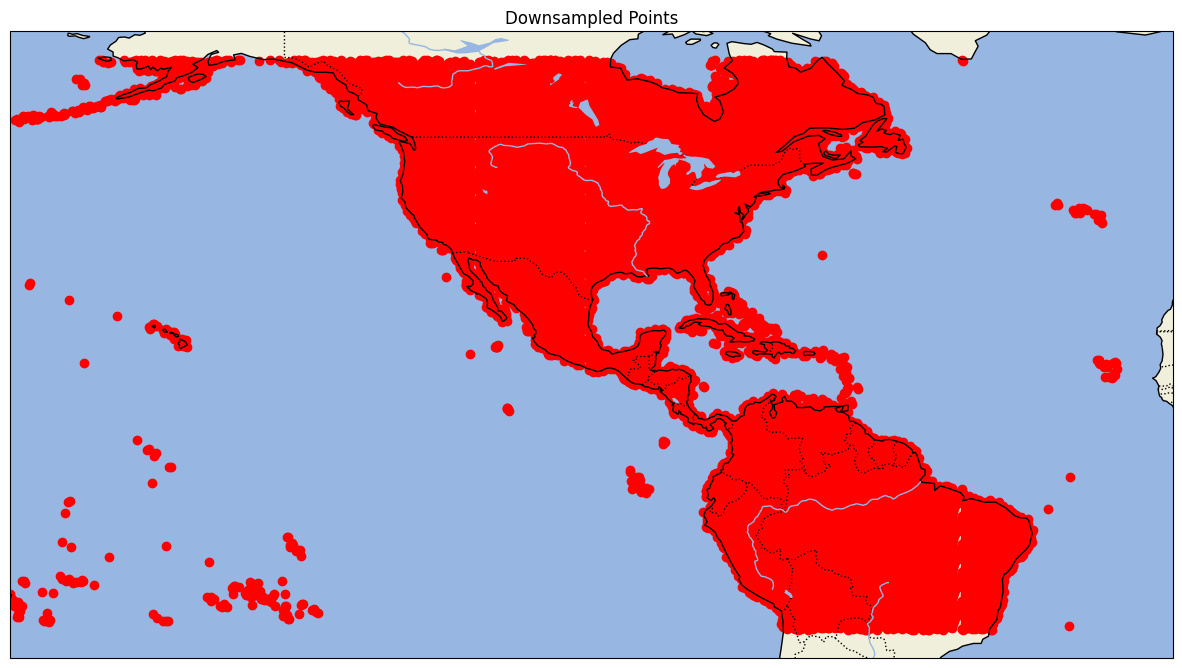

In [36]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

ax.scatter(meta_sub['longitude'], meta_sub['latitude'], color='red',transform=ccrs.PlateCarree())

plt.title('Downsampled Points')

We want to look for mountains. can either brute force or build kdtree or other datastructure for quick lookups. Probably worth it because there are 2e8 location entries in the original dataset for 2022.

Identifying characteristics of mountains.
- higher than surroundings (by how much?) dynamic thresholding?

In [ ]:
coordinates = meta_sub[['latitude', 'longitude']].values
elevations = meta_sub['altitude'].values

tree = KDTree(coordinates, leaf_size=40) # what is the optimal leaf size

joblib.dump(tree, 'kdtree.pkl')